# Theory Kernel Analysis

*Lukas Snoek, Rachael Jack, Philippe Schyns, Oliver Garrod, Maximilian Mittenbuhler, Suzanne Oosterwijk, H. Steven Scholte*\*

This notebook describes how "theory kernels" can be used to formalize and quantify action-unit based theories. It primarily meant as a demonstration of the method and to showcase some preliminary results (i.e., not as a paper draft). It contains code to explain the idea, but this will obviously not be part of the actual paper. The blocks with "To add/chance" are mental notes about concepts that I think need to be incorporated in the paper at some point.

\* The author order is a suggestion, but can be changed of course! (Max is a student with whom I came up with the idea of theory kernels.)

---

**To do**:

* Writing: check consistency terminology and mathematical notation(theory, class, vector)
* Analysis: statistical analyses of model comparisons (with $p$-values and all that)

---

# Introduction
Facial expressions are a powerful and efficient medium to express and transmit internal cognitive and affective states, which has been investigated thoroughly in the context of emotion experience and perception. Since the pioneering work by Paul Ekman (ref), studies have tried to describe and quantify how, on the one hand, affective states generate facial expressions and, on the other hand, how affective states are inferred from facial expressions. Central to this endeavor are "action units" &mdash (groups of) muscles that realize different facial movements. Previous studies have shown that experience of different (categorical) emotions reliably activate specific configurations of action units (ref, ref, ref; but see Barrett et al., 2019). Similarly, other studies have shown that specific configurations of action units reliably lead to the perception of different categorical emotions (ref, ref).

However, there is no full agreement about the exact mapping between emotion (both in terms of experience and perception) and action units. Since Ekman (ref), there have been many different "theories" about this mapping. These theories, while often supported by quantitative analyses, are limited in their value as a *model* of emotion perception as they lack the ability to predict (out-of-sample) data. As a consequence, these theories are difficult to compare quantitatively. In this study, we develop a novel way to formalize such action unit based theories of emotional facial expression perception, "theory kernel analysis", which allows us to compare the accuracy of diffent theories on an extensive set of psychophysics data. In addition, we develop a novel approach to estimate an upper bound of such a predictive model (a "noise ceiling") given the between-subject variance in the data, which gives insight into the model's limitations and generalizability.

## Action unit based theories of emotional facial expression perception
* Discuss the idea of "building blocks"/ontology of emotion generation $\approx$ emotion perception (with caveats), cf. Darwin (Jack & Schyns papers: facial expressions as information transmission)
* Summarize/discuss different theories/hypotheses about theoretical AU configurations and how they come about (reverse correlation, cross-cultural research, etc.; Jack et al., 2018, TiCS; Cordaro et al., 2018)
* Pitfalls of estimating *effects* ($\hat{\beta}$), see Meehl; move towards *prediction* (i.e., $\hat{y}$; Yarkoni & Westfall)

---

**To add**: maybe mention here that assuming "fixed" AU &rarr; emotion mappings are often hypothesized as part of "basic emotion theory" and that we, here, want to investigate _quantitatively_ how well these mappings perform and, importantly, to show using noise ceilings what the limit of such fixed mappings are (as is often argued by constructionist theories). (Note that I really don't want to take sides in this debate! I think these results should be interpreted as evidence for both BET and constructionism.)

---

## What's in a model?
* Explain difference between statistical model and data/generative model (we're talking about the latter)
* A model is quantitative; allows for prediction of new data (Kay, 2018; Guest & Martin, 2020)
* May or may not contain (to-be-estimated) parameters
* Importantly, formalized models allow for model *comparison* (Palmeri et al., 2017)

## Current study
* Introduce the idea of "theory kernel analysis" broadly (more details in methods section)
* Mention that this idea is not limited to AU-based theories nor (categorical) emotion perception
* Mention that this idea is best used with psychophysics data (not traditional NHST condition/manipulation-based experiments)

# Methods

## The proposed method
To evaluate AU-based theories of emotional facial expression perception, we propose to formalize those theories as points in "AU space". Subsequently, using discrete emotion ratings of facial expression stimuli with known AU configurations, we can embed those stimuli in the same AU space and derive quantitative emotion predictions based on their similarity &mdash; computed using a *kernel function* &mdash; to the points representing the different theories. Finally, these predictions can be evaluated by comparing them to actual emotion ratings from human participants.

---

**To add**: add figure with visualization of method

---

As such, our proposed analysis involves four elements: the encoding of theories in AU space, the encoding of stimuli in AU space, a kernel function to generate predictions, and a metric to summarize accuracy of the theory, which are discussed in turn below.

### Encoding theories
An important concept in our method is the embedding of AU theories (and stimuli with known AU configurations, discussed in the next subsection) into $D$-dimensional numerical vectors, which represent hypotheses of how AU configurations map onto categorical emotions. To explain this concept, suppose that for simplicity we are dealing with theories that are based on a limited set of 10 AUs outlined below:

\begin{align}
\mathrm{AU} = \{\mathrm{AU}1, \mathrm{AU}2, \mathrm{AU}4, \mathrm{AU}5, \mathrm{AU}6, \mathrm{AU}7, \mathrm{AU}9, \mathrm{AU}12, \mathrm{AU}15, \mathrm{AU}26\} 
\end{align}

In code:

In [1]:
# {*} is a set in Python
AU = {'AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU12', 'AU15', 'AU26'}

In other words, in this example, we are dealing with a 10-dimensional AU space ($D=10$). Now, assume that a particular theory, $T$, suggests that humans express the categorical emotion "happiness" using a combination of AU12 and AU6 (the "Duchenne smile"). Within our 10-dimensional AU space, we can "encode" this hypothesis as a binary 10-dimensional vector containing ones at positions associated with AUs that are hypothesized to be used in displaying happiness and zeros elsewhere:

\begin{align}
T_{\mathrm{happy}} =
\begin{bmatrix}
0, 0, 0, 0, 1, 0, 0, 1, 0, 0
\end{bmatrix}
\end{align}

Let's also implemented this in code as a 10D row vector:

In [2]:
import numpy as np
T_happy = np.array([[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]])
print(T_happy.shape)

(1, 10)


Note that, in the above example, values at the positions of hypothesized AUs are all coded 1, which implies that each AU contributes equally to that emotions configuration. This does not have to be the case; if, for example, a particular theory hypothesizes that a particular emotion, $e$, maps onto a combination of AU1 and AU2, but AU1 is thought to be twice as important as AU2, then its theory vector can be constructed as follows: 

\begin{align}
T_{e} = \begin{bmatrix} 1, .5, 0, 0, 0, 0, 0, 0, 0, 0 \end{bmatrix}
\end{align}

For simplicity, we assume in this example that each hypothesized AU is equally important (such that theory vectors are binary). Importantly, often, theories hypothesize mappings onto multiple (categorical) affective states ($1 \dots M$), which we will refer to as *classes*. Here, we assume that our hypothetical theory $T$ limits its mappings to the six basic emotions (i.e., $M = 6$). Specifically, suppose that theory $T$ also hypothesizes specific AU-emotion mappings for the following categorical emotions:

* anger: AU4, AU5, AU7
* disgust: AU9, AU15
* fear: AU1, AU2, AU4, AU7, AU26
* sadness: AU1, AU4, AU15
* surprise: AU1, AU2, AU5, AU26

Accordingly, we can encode the entire set of AU-emotion mappings for a given theory with $M$ classes and $D$ dimensions into a $M \times D$ matrix, effectively vertically stacking the $M$ different row vectors. For our hypothetical theory $T$, its associated "theory matrix" would look like the following:

\begin{align}
T = 
\begin{bmatrix}
0, 0, 1, 1, 0, 1, 0, 0, 0, 0 \\
0, 0, 0, 0, 0, 0, 1, 0, 1, 0 \\
1, 1, 1, 0, 0, 1, 0, 0, 0, 1 \\
0, 0, 0, 0, 1, 0, 0, 1, 0, 0 \\
1, 0, 1, 0, 0, 0, 0, 0, 1, 0 \\
1, 1, 0, 1, 0, 0, 0, 0, 0, 1 \\
\end{bmatrix}
\end{align}

where its rows represent the different classes (emotions):

\begin{align}
E = \{\mathrm{Anger}, \mathrm{Disgust}, \mathrm{Fear}, \mathrm{Happiness}, \mathrm{Sadness}, \mathrm{Surprise}\}
\end{align}

In [3]:
E = {'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'}

Although the above represents a hypothetical theory, its sparsity is something we would expect, as facial expressions are unlikely to be generated by a full (dense) set of action units. Again, let's implement this construct as a 2D array:

In [4]:
# We use Th instead of T to prevent confusion with an array's transpose (.T)
Th = np.array([
    [0, 0, 1, 1, 0, 1, 0, 0, 0, 0],  # anger
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],  # disgust
    [1, 1, 1, 0, 0, 1, 0, 0, 0, 1],  # fear
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],  # happiness
    [1, 0, 1, 0, 0, 0, 0, 0, 1, 0],  # sadness
    [1, 1, 0, 1, 0, 0, 0, 0, 0, 1]   # surprise
])
print(Th.shape)

(6, 10)


### Encoding stimuli
In order to evaluate AU-based theories of emotional facial expression perception, we need to evaluate how well these theories are able to predict actual categorical emotion ratings of human participants on stimuli with known AU configurations. Ideally, these theories are evaluated using data from experiments that sample as much as possible of the AU space. Many experiments on emotional facial expression perception, however, use posed and stereotyped stimuli (e.g., facial expressions of extreme joy or anger), which cover only a small part of the entire AU space and thus do not allow for unbiased evaluation of AU-based theories. In contrast, AU-focused psychophysics experiments, which are characterized by randomly and parametrically varying the input space (defined by AU configurations) and collection of resulting percepts (here: perception of categorical emotion) do not impose such contraints (ref Jack).

Now, assume there is such psychophysics-style data available, i.e., that we have a set of $N$ stimuli $S_{1 \dots N}$, generated with random AU configurations (drawn from the previously defined set $\mathrm{AU}$), with associated categorical emotion labels $e_{1 \dots N} \in E$. The next step in our analysis is to encode these stimuli in AU space in the same way we did for the hypothetical theory. To do so, we need to assume that each stimulus, $S_{i}$, was generated with one or more AUs drawn from the same set that was used to encode the theories in AU space. Then, we can create for each stimulus $S_{i}$ an associated $D$-dimensional binary stimulus vector containing nonzero values at positions associated with active AUs for that stimulus and zeros elsewhere. Note that, the nonzero values at positions associated with active AUs can be all ones (if assumed to be equally "active") or be values proportional to the amplitude (or "activity") of the active AUs.

For example, suppose that stimulus $S_{i}$ contains AU1, AU5, and AU26 which were actived with amplitudes 0.1, 0.5, and 0.8. Then, formally, we can represent this particular stimulus, $S_{i}$, as a 10-dimensional vector:

\begin{align}
S_{i} = 
\begin{bmatrix}
0.1, 0, 0, 0.5, 0, 0, 0, 0, 0, 0.8
\end{bmatrix}
\end{align}

Let's also define this as an actual vector:

In [5]:
S_i = np.array([[0.1, 0, 0, 0.5, 0, 0, 0, 0, 0, 0.8]])

Given that both our theories ($T$) and stimuli ($\mathbf{S}$) are encoded as vectors in $D$-dimensional AU space, we can discuss using *kernels* to generate quantitative predictors for stimuli given a particular theory.

### Kernel functions
Within our theory kernel analysis framework, *kernel functions* (or simply *kernels*) are functions that are, broadly speaking, measures of similarity between two vectors. Applied to our use case, we use kernel functions ($\kappa$) to quantify the similarity ($\phi$) between a stimulus with a known action unit configuration ($S_{i}$) and a theory vector for a specific emotion, $j$ ($T_{j}$, e.g., happiness)\*: 

\begin{align}
\phi_{i,j} = \kappa(S_{i}, T_{j})
\end{align}

Most (linear) kernel functions are based on the dot (inner) product of the theory vector ($T_{j}$) and the stimulus vector ($S_{i}$). In fact, a "linear kernel" is just this:

\begin{align}
\kappa(S_{i}, T_{j}) = S_{i}T^{T}_{j}
\end{align}

In fact, the similarity between two vectors as computed with a linear kernel is proportional to the covariance between two vectors. In this section, we will use the linear kernel for its simplicity, but our proposed method can in principle be used with any linear or non-linear kernel, such as the "sigmoid kernel": $\tanh(\gamma S_{i}^{T}T_{j} + c_{0}$).

---
\* Instead of using measures of *similarity* between two vectors (i.e., "kernels"), one could use measures of *distances* ($\delta_{i,j}$) between two vectors instead and subsequently invert it to get a similarity score again, i.e., $\phi_{i,j} = \delta_{i,j}^{-1}$. In practice, we find that it does not make much of a difference in terms of predictive performance (see Supplementary Figure X).

In [6]:
j = 0  # anger
phi_ij = np.squeeze(S_i @ Th[j, :].T)
print(f"Similarity between S_i and T_j: {phi_ij}")

Similarity between S_i and T_j: 0.5


Note that the absolute magnitude of the similarity to a given class $j$ is not necessarily interpretable, but should be interpreted relative to the similarities to the other classes. To compute the similarity for all classes ($j = 1 \dots M$), one extend the kernel to compute the similarity between a stimulus vector ($S_{i}$) and a full theory *matrix* ($T$):

In [7]:
import seaborn as sns  # plotting lib

phi_i = S_i @ Th.T
ax = sns.barplot(sorted(list(E)), phi_i.squeeze())
ax.set_ylabel(r'$\phi_{i}$ (linear kernel)', fontsize=20);

(Similarly, the linear kernel accomodates computing the similarity for multiple stimuli, stored in an $N \times D$ stimulus *matrix*, as well.)

While the similarity to a given theory class vector is arguably proportion to the evidence for that particular class, it is not strictly speaking a *prediction*. To generate a prediction for stimulus $S_{i}$ (i.e., $\hat{e}_{i}$), one can determine the prediction as the emotion ($j = 1 \dots M$) that maximizes its similarity, for some kernel function ($\kappa$), to the stimulus:

\begin{align}
\hat{e}_{i} = \underset{j}{\operatorname{argmax}}\kappa(S_{i}, T_{j})
\end{align}

Below, this is implemented in code by taking the argmax of the dot product (linear kernel) between the stimulus and the theory array:

In [8]:
e_hat = np.argmax(S_i @ Th.T)
print(f"Discrete prediction for S_i: {e_hat} ({sorted(list(E))[e_hat]})")

Discrete prediction for S_i: 5 (surprise)


In a slightly more sophisticated version, we can generate *probabilistic* predictions, e.g., $p(E | T, S_{i})$ by normalizing each of the $j = 1 \dots M$ similarities ($\phi_{i,j}$), to the 0-1 range using the softmax function:

\begin{align}
P(E_{j} | T, S_{i}) = \sigma(\phi_{i, j}) = \frac{e^{\beta\phi_{i, j}}}{\sum_{j=1}^{M} e^{\beta\phi_{i, j}}}
\end{align}

where $\beta$ is the "inverse temperature" parameter &mdash; a scaling parameter &mdash; which distributes relatively more mass onto the largest values. In our framework, we can treat this parameter as a model hyperparameter (i.e., a parameter that is not fit, but manually tuned using cross-validation).

It is implemented as follows:

In [9]:
def softmax(phi, beta):
    """ Softmax function with inverse temperature (beta) parameters.
    
    Parameters
    ----------
    phi : array
        Similarities for M classes
    beta : int/float
        Inverse temperature parameter
        
    Returns
    -------
    p : array
        Probabilities for M classes
    """
    bphi = beta * phi
    # max value is subtracted to prevent overflow
    p = np.exp(bphi - np.max(bphi)) / np.sum(np.exp(bphi - np.max(bphi)))
    
    # Get rid of singleton dimension, if there is one
    if p.shape[0] == 1:
        p = np.squeeze(p)

    return p

Applying it to our hypothetical stimulus vector $S_{i}$, with different values for $\beta$ (i.e., 1 and 3) gives the following discrete probability distributions across emotions:

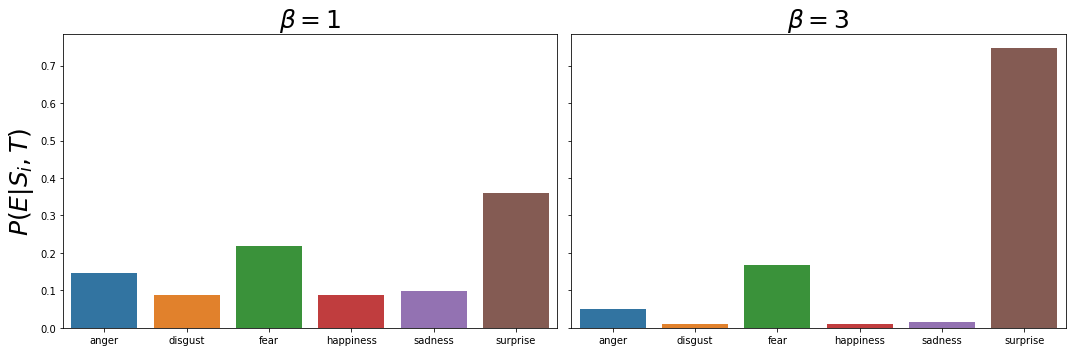

In [10]:
import matplotlib.pyplot as plt

# Get probs for two different betas
p_b1 = softmax(S_i @ Th.T, beta=1)
p_b3 = softmax(S_i @ Th.T, beta=3)

# Plot both prob. distributions
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.barplot(x=sorted(list(E)), y=p_b1, ax=axes[0])
axes[0].set_ylabel(r"$P(E | S_{i}, T)$", fontsize=25)
axes[0].set_title(r"$\beta = 1$", fontsize=25)
sns.barplot(x=sorted(list(E)), y=p_b3, ax=axes[1])
axes[1].set_title(r"$\beta = 3$", fontsize=25)
fig.tight_layout()

Note that increasing the $\beta$ parameter forces more mass onto the class with the highest similarity. Indeed, in the limit, a softmax with an infinite inverse temperature parameter yields a discrete predictor (argmax across the similarity scores).

As a side note: instead of the softmax function, you could also use a simple linear probability normalization function (instead of an exponential one like the softmax function): $P(E_{j} | T, S_{i}) = \frac{\phi_{i, j}}{\sum_{j=1}^{M} {\phi_{i, j}}}$. In practice, this does not yield any performance improvement over softmax normalization, and because the latter is standard practice in many models (e.g., multinomial logistic regression), we stick with softmax normalization for our analyses.

### Quantifying model performance
To evaluate each theory, we can compare their (discrete or probabilistic) predictions for a set of stimuli with data from participants who actually rated those same stimuli in terms of perceived emotion. In other words, we can quantitatively assess how well the theoretical predictions match with actual behavior.

In our analyses, we used the "area under the curve of the receiver operating characteristic" (AUROC) which summarizes the quality of probabilistic predictions in a range from 0 to 1, where 0.5 is chance level performance and 1 is a perfect prediction. For example, suppose we have the following stimuli:

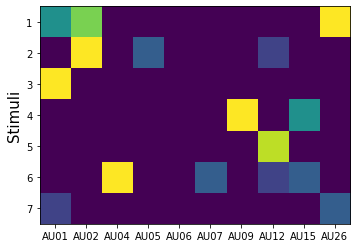

In [11]:
S = np.array([
    [.5, .8, 0., 0., 0., 0., 0., 0., 0., 1.],  # disgust
    [0., 1., 0., .3, 0., 0., 0., .2, 0., 0.],  # surprise?
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # sadness
    [0., 0., 0., 0., 0., 0., 1., 0., .5, 0.],  # happy
    [0., 0., 0., 0., 0., 0., 0., .9, 0., 0.],  # fear
    [0., 0., 1., 0., 0., .3, 0., .2, .3, 0.],  # anger
    [.2, 0., 0., 0., 0., 0., 0., 0., 0., .3]   # disgust
])

# Let's plot it as a "heatmap"
plt.imshow(S)
plt.xticks(range(S.shape[1]), sorted(list(AU)))
plt.yticks(range(S.shape[0]), range(1, S.shape[0] + 1))
plt.ylabel("Stimuli", fontsize=15);

And suppose those stimuli, for a given participant, were rated with the following emotions:

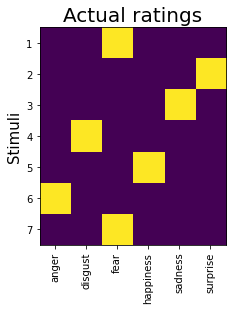

In [12]:
# e_lab = emotion LABels
e_lab = ['fear', 'surprise', 'sadness', 'disgust', 'happiness', 'anger', 'disgust']

# e_int = emotion INTegers
e_int = np.array([2, 5, 4, 1, 3, 0, 2])

# "One-hot encode" ratings
e_int = np.vstack([np.arange(6) == ei for ei in e_int]).astype(int)

# Let's plot it as a heatmap
plt.imshow(e_int)
plt.title("Actual ratings", fontsize=20)
plt.xticks(range(6), sorted(list(E)), rotation=90)
plt.yticks(range(S.shape[0]), range(1, S.shape[0] + 1))
plt.ylabel('Stimuli', fontsize=15);

To get our predictions, we compute the similarity between each stimulus and each class in our theory matrix ($T$), which are subsequently normalized using the softmax function:

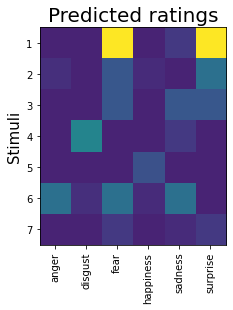

In [13]:
e_hat = softmax(S @ Th.T, beta=1)
plt.imshow(e_hat, vmin=0, vmax=e_hat.max())
plt.title("Predicted ratings", fontsize=20)
plt.xticks(range(6), sorted(list(E)), rotation=90)
plt.yticks(range(S.shape[0]), range(1, S.shape[0] + 1))
plt.ylabel('Stimuli', fontsize=15);

Finally, to evaluate how "good" these predictions are, we will use the AUROC score, which will by default (in *scikit-learn*'s implementation) yield the class-average AUROC score:

In [14]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(e_int, e_hat)

But we can also get the score *per class* (i.e., per emotion):

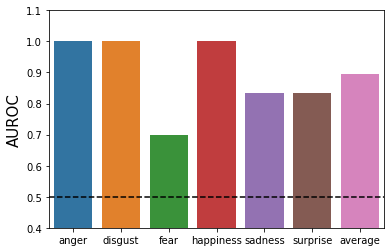

In [15]:
score_per_class = roc_auc_score(e_int, e_hat, average=None)

# Let's plot all scores (average and class-specific)
ax = sns.barplot(sorted(list(E)) + ['average'], np.append(score_per_class, score))
ax.axhline(0.5, ls='--', c='k')
ax.set_ylabel('AUROC', fontsize=15)
ax.set_ylim(0.4, 1.1);

Note that our method does not require a specific performance metric. We prefer to use AUROC as it can be used for both discrete and probabilistic predictions and is insensitive to class imbalance (i.e., unequal frequencies of target classes). 

## Noise ceiling estimation
Suppose that, for a given dataset, we find that our theory kernel analysis yields a (class-average) AUROC score of 0.8 &mdash; what can and should be conclude from this score? It is certainly above chance level (a score of 0.5) but also substantially below perfect performance (i.e., a score of 1). Here, we argue that one should not interpret performance relative to a theoretical maximum score, but relative to a *noise ceiling* &mdash; a concept borrowed from systems neuroscience (ref Gallant & co) &mdash; which represents an upper bound that incorporates the between-subject variance in ratings. In other words, a noise ceiling is a way to estimate an upper bound for predictive models that is adjusted for "consistency" or "measurement error" across subjects.

---

**To add**: add figure visualizing noise ceiling estimation

---

While noise ceilings are routinely used in systems and cognitive neuroscience, existing methods for estimating noise ceilings are limited to regression models (assuming a continuous target variable, usually some type of brain measurement). In the current study, however, we are dealing with *classification* models, as we are trying to predict a categorical target variable (i.e., categorical emotion ratings). Here, we propose a novel approach to estimate a noise ceiling for predictive performance of classification models.

An crucial and necessary element for most noise ceiling estimation methods is the availability of *repeated observations*, because variance (or, inversely, the "consistency") between repeats is used to estimate an upper bound. In this study, we can conceptualize the ratings of the same set of trials across subjects as repeated observations (e.g., twelve participants ratings the same stimulus $S_{i}$ counts as twelve repetitions of that trial). (Note that this type of "between-subject" noise ceiling can also be applied to within-subject models, which needs stimulus repeats; see Supplementary Figure X)

To make this more clear, suppose that there are three subjects who all rated the same stimuli ($S_{1}, S_{2}, S_{3}$). For now, we'll restrict this example to only two stimuli ($S_{1}$ and $S_{2}$). The first stimulus ($S_{1}$) was rated as "surprise" by subject 1, but as "disgust" by subject 2 and 3. Conversely, the second stimulus ($S_{2}$) was rated as "disgust" by participant 1 and 2, but as "surprise" by subject 3.

In code:

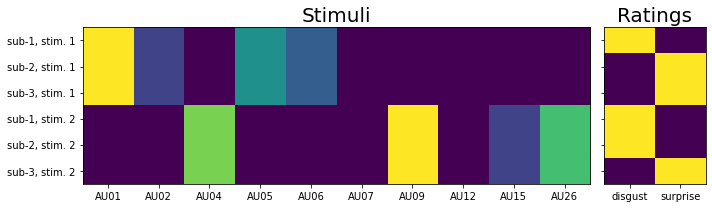

In [16]:
n_sub = 3
n_trial = 2

S1 = np.array([1., .2, 0., .5, .3, 0., 0., 0., 0., 0.])
S2 = np.array([0., 0., .8, .0, 0., 0., 1., 0., .2, 0.7])

# Repeat stimulus 3 times
S = np.vstack((
    np.tile(S1, n_sub).reshape(n_sub, 10),
    np.tile(S2, n_sub).reshape(n_sub, 10),
))

trial_idx = np.repeat(range(n_trial), n_sub)

e = np.array([0, 1, 1, 0, 0, 1])
# One-hot-encoded
e = np.vstack([np.arange(2) == ei for ei in e]).astype(int)

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 3),
                         gridspec_kw={'width_ratios':[10, 2]})

axes[0].imshow(S, aspect='auto')
axes[0].set_xticks(range(S.shape[1]))
axes[0].set_xticklabels(sorted(list(AU)))
axes[0].set_yticks(range(S.shape[0]))
ytk = [f'sub-{s+1}, stim. {i+1}' for i, s in
       zip(np.repeat(range(n_trial), n_sub), np.tile(range(n_sub), n_trial))]
axes[0].set_yticklabels(ytk)
axes[0].set_title("Stimuli", fontsize=20)

axes[1].imshow(e, aspect='auto')
axes[1].set_xticks(range(e.shape[1]))
axes[1].set_xticklabels(['disgust', 'surprise'])
axes[1].set_yticks(range(e.shape[0]))
axes[1].grid(which='minor')
axes[1].set_title("Ratings", fontsize=20)

fig.tight_layout()

In order to establish an upper bound, we need to derive the *optimal* prediction a classifier can make, given that it should make *the same* prediction for each repeated trial/stimulus. In case of discrete predictions, this is the mode (i.e., most often occuring) of the ratings per stimulus. In our example, that would be "surprise" for stimulus 1 and "disgust" for stimulus 2. Deriving an optimal discrete prediction becomes more complicated when there is no unique mode, however. An alternative which avoids having to deal with "ties" is to use probabilistic predictions as discussed before. Here, the optimal prediction is computed as the proportion of ratings for each class (for a given stimulus):

\begin{align}
\mathbf{e}_{\mathrm{opt}^{M}} = \mathrm{not\ sure\ about\ how\ to\ formulate\ this}
\end{align}

In code:

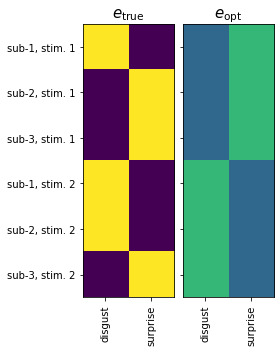

In [17]:
e_opt = np.zeros_like(e, dtype=float)
for t in range(n_trial):
    idx = trial_idx == t
    # Get frequency of each rating
    counts = np.bincount(e[idx, :].argmax(axis=1))
    # Normalize by number of ratings (0-1 scale)
    e_opt[idx, :] = counts / counts.sum()

# And plot it
fig, axes = plt.subplots(ncols=2, figsize=(4, 5), sharex=True, sharey=True)
axes[0].imshow(e, vmin=0, vmax=1)
axes[0].set_xticks(range(2))
axes[0].set_xticklabels(['disgust', 'surprise'], rotation=90)
axes[0].set_yticks(range(n_trial * n_sub))
axes[0].set_yticklabels(ytk)
axes[0].set_title(r"$e_{\mathrm{true}}$", fontsize=15)
axes[1].imshow(e_opt, vmin=0, vmax=1)
axes[1].set_xticklabels(['disgust', 'surprise'], rotation=90)
axes[1].set_title(r"$e_{\mathrm{opt}}$", fontsize=15)
fig.tight_layout()

Now, we can compute the noise ceiling as the performance (for a given metric, $f$) of our model using these optimal predictions ($\mathbf{e}_{\mathrm{opt}}$):

\begin{align}
\mathrm{noise\ ceiling} = \mathrm{f}(\mathbf{\hat{e}}, \mathbf{e}_{\mathrm{opt}})
\end{align}

In code:

In [18]:
nc = roc_auc_score(e, e_opt, average=None)
print(f"Noise ceiling: {nc.round(3)}")

Noise ceiling: [0.667 0.667]


As expected, the noise ceiling reflects the proportion of trials that match the most frequent class label. Note that while the noise ceiling is a true upper bound for the dataset that it is computed on, it represents an *estimate* of the true population upper bound. To estimate the variance of this estimate, we use a bootstrapping procedure in which we resample the set of repeated stimuli with replacement. Also, note that the noise ceiling is computed as function of the target variable (here, $\mathbf{e}$) and is thus the same for any model that is used to predict them.

---

**To add**: some caveats with respect to interpretation of the noise ceiling. The difference between theoretical max performance and the noise ceiling should not be interpreted as _irreducible_ noise. It represents an upper bound with respect to _this particular model_ (or feature space). More sophicated models that, for example, add information about the face identity/gender/etc may not only improve absolute performance but may also increase the noise ceiling. Another way to increase the (between-subject) noise ceiling is to add factors that may _explain_ between-subject variance, such as participant gender/age or personality scores. 

---

## Evaluated theories
Many action unit based theories of emotion (perception) have been put forward, but in this study we assessed those summarized in the article by [Barrett and colleagues](https://journals.sagepub.com/doi/full/10.1177/1529100619832930)  (2019; table 1). Additionally, we included the Ekman configuration (2002; taken from [Clark et al., 2020](https://www.frontiersin.org/articles/10.3389/fpsyg.2020.00920/full), Table 3). So, in total, we evaluated five hypothesized sets of action unit configurations ("theories", for simplicity):

* Darwin (from Matsumoto, 2008)
* Matsumoto 2008
* Keltner 2009
* Cordaro 2008 (reference configuration)
* Ekman (2002)

---

**To add/extend**: Are there any other "key" AU-based theories than these? Should we also include one from Glasgow? E.g., the one from the original Yu et al. paper? Maybe add a (cross-validated) version of a standard psychophysics "model" (binary correlations) estimated on this dataset?

---

Some theories described in Barrett et al. (2019) include AUs that either *must* occur together (e.g., in Kelter et al., 2009, "sadness" is thought to be expressed with AUs 1 + 4 + 6 + 15 + 17) while other AUs are optional (e.g., in Ekman, 2002, "happiness" may be expressed with either AU12 or a combination of AU12 and AU6). When AUs must occur together, we encode them as such, but when configurations include on or more optional AUs, each possible configuration is encoded with a separate vector. For example, Ekman (2002) hypothesizes that "happiness" is expressed with AU12 and optionally AU6, so we create two theory vectors: one with only AU12 and one with both AU12 and AU6. Moreover, some theories offer completely different configurations for a given emotion; for example, Matsumoto et al. (2008) suggest that "anger" may be expressed with AU4+5 *or* AU7+22+23+24. In those cases, we also create different vectors for each hypothesized configuration.
    
Below, the encoding of the theories is shown (stored in a nested dictionary):

In [19]:
import sys
sys.path.append('../src')
from theories import THEORIES

# A dictionary with theories
print(f"THEORIES contains the following theories:\n{list(THEORIES.keys())}")

THEORIES contains the following theories:
['Darwin', 'Matsumoto2008', 'Keltner2019', 'Cordaro2008ref', 'Ekman']


Each theory contains configurations for different emotions:

In [20]:
# let's take Keltner2019 as an example
print(f"There are configurations for the following emotions:\n{list(THEORIES['Keltner2019'].keys())}")

There are configurations for the following emotions:
['happiness', 'sadness', 'surprise', 'fear', 'anger', 'disgust']


And these configurations consist of a list of AUs that are hypothesized to be indicative of a particular emotion. Note that they are not yet encoded as a $M \times P$ matrix.

In [21]:
for emo in THEORIES['Keltner2019']:
    print(f"{emo}: {THEORIES['Keltner2019'][emo]}")

happiness: ['AU06L', 'AU06R', 'AU07L', 'AU07R', 'AU12L', 'AU12R', 'AU25', 'AU26']
sadness: ['AU01', 'AU04', 'AU06L', 'AU06R', 'AU15', 'AU17']
surprise: ['AU01', 'AU02L', 'AU02R', 'AU05', 'AU25', 'AU26']
fear: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU07L', 'AU07R', 'AU20', 'AU25']
anger: ['AU04', 'AU05', 'AU17', 'AU23', 'AU24']
disgust: ['AU07L', 'AU07R', 'AU09', 'AU25', 'AU26']


As discussed, some theories contain multiple configurations for a given emotion. A prominent example is Ekman's theory, which contains up to 16 configurations for some emotions (e.g., for fear):

In [22]:
print(f"Configurations for fear in Ekman:")
for i, cfg in THEORIES['Ekman']['fear'].items():
    print(f"{i+1}: {cfg}")

Configurations for fear in Ekman:
1: ['AU01', 'AU02L', 'AU02R', 'AU04']
2: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU20', 'AU25']
3: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU20', 'AU26']
4: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU20', 'AU27']
5: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU25']
6: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU26']
7: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU27']
8: ['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05']
9: ['AU01', 'AU02L', 'AU02R', 'AU05', 'AU25']
10: ['AU01', 'AU02L', 'AU02R', 'AU05', 'AU26']
11: ['AU01', 'AU02L', 'AU02R', 'AU05', 'AU27']
12: ['AU05', 'AU20', 'AU25']
13: ['AU05', 'AU20', 'AU26']
14: ['AU05', 'AU20', 'AU27']
15: ['AU05', 'AU20']
16: ['AU20']


As described before, we can transform these configurations into $P$ dimensional binary "theory vectors". In our dataset, there are $P = 34$ different AUs. Note that originally, the stimuli in this dataset were parameterized with 42 different AUs. This original AU set, however, contained both *compound* AUs (such as *AU25-12* and *AU1-2*) and AUs that could be activated both unilaterally (left or right) and bilaterally (such as *AU12*). In order to encode these stimuli into independent values within the theory vectors, we recoded the compound AUs (e.g., activation of AU1-2 is recoded as activation of both AU1 and AU2) and bilateral AUs (e.g., activation of AU12 is recoded as activation of both AU12L and AU12R), yielding a total of 34 AUs:

In [23]:
# Load in list of theory matrices
import pandas as pd
t_df = {t: pd.read_csv(f'../data/{t}.tsv', sep='\t', index_col=0) for t in THEORIES.keys()}

# Show list of parameters
print(t_df['Darwin'].columns.tolist())

['AU01', 'AU02L', 'AU02R', 'AU04', 'AU05', 'AU06L', 'AU06R', 'AU07L', 'AU07R', 'AU09', 'AU10L', 'AU10R', 'AU11L', 'AU11R', 'AU12L', 'AU12R', 'AU13', 'AU14L', 'AU14R', 'AU15', 'AU16', 'AU17', 'AU20', 'AU20L', 'AU20R', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU38', 'AU39', 'AU43']


For example, the "Darwin" theory matrix looks as follows:

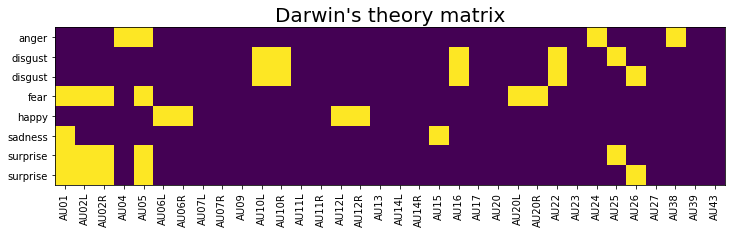

In [24]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.imshow(t_df['Darwin'])
ax.set_title("Darwin's theory matrix", fontsize=20)
ax.set_xticks(range(t_df['Darwin'].shape[1]))
ax.set_xticklabels(t_df['Darwin'].columns, rotation=90)
ax.set_yticks(range(t_df['Darwin'].shape[0]))
ax.set_yticklabels(t_df['Darwin'].index);

In the figure above, you can see that Darwin's theory shows multiple configurations for both disgust and surprise, which only differ in a single AU (AU25 vs. AU26).

Another way to visualize these theory matrices is to embed them as points in 2D dimensional space using a dimensionality reduction technique called *multidimensional scaling* (MDS). Specifically, using MDS, we can project the different AU configurations (i.e., rows of our theory matrices), which are 34-dimensional vectors, to points in 2D space, in which the high-dimensional (34D) distances between points are preserved as much as possible in the lower-dimensional (2D) space. This embedding (and its visualization) will prove especially helpful in interpretation of our method later.

Below, we fit the MDS algorithm on all theory matrices at the same time, but visualize the embedding per theory separately in 2D space:

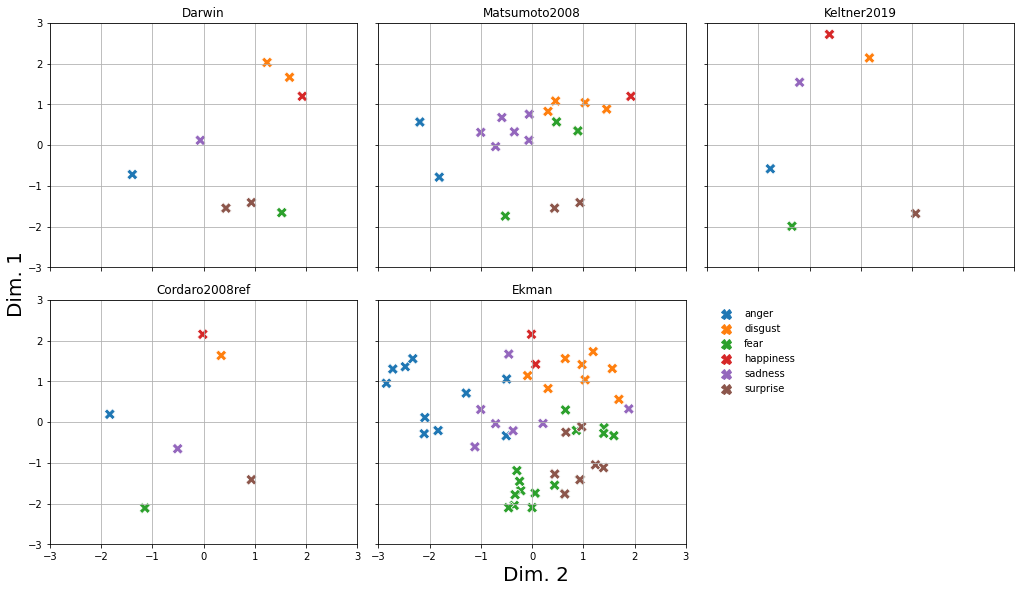

In [25]:
import matplotlib.lines as mlines
from sklearn.manifold import MDS

theories = list(THEORIES.keys())
idx = np.concatenate([[i] * t_df[key].shape[0] for i, key in enumerate(theories)])
mds = MDS(random_state=42)
# Fit MDS on all (i.e., concatenated) theory matrices
t_mds = mds.fit_transform(pd.concat(t_df, axis=0))

# Plot each embedding separately
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()[:-1]):
    this_mds = t_mds[idx == i, :]
    sns.scatterplot(this_mds[:, 0], this_mds[:, 1], hue=t_df[theories[i]].index, ax=ax,
                    legend=False, marker='X', s=120)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid()
    ax.set_title(list(THEORIES.keys())[i])
    
ax = axes.flatten()[-1]
ax.axis('off')
current_palette = sns.color_palette()
ax.legend(handles=[mlines.Line2D([], [], color=current_palette[i], marker='X', linestyle='None',
                   markersize=10, label=e) for i, e in enumerate(sorted(list(E)))], loc='upper left', frameon=False)
fig.text(-0.01, 0.5, 'Dim. 1', fontsize=20, rotation=90, va='center')
fig.text(0.515, -0.015, 'Dim. 2', fontsize=20, ha='center')
fig.tight_layout();

And yet another way to visualize the relation of the different configurations is to look at their (high-dimensional) similarity (instead of looking at distances, as is done with MDS):

---

**Note**: I think the correlation plots below may be redundant, but I included them here for completeness.

---

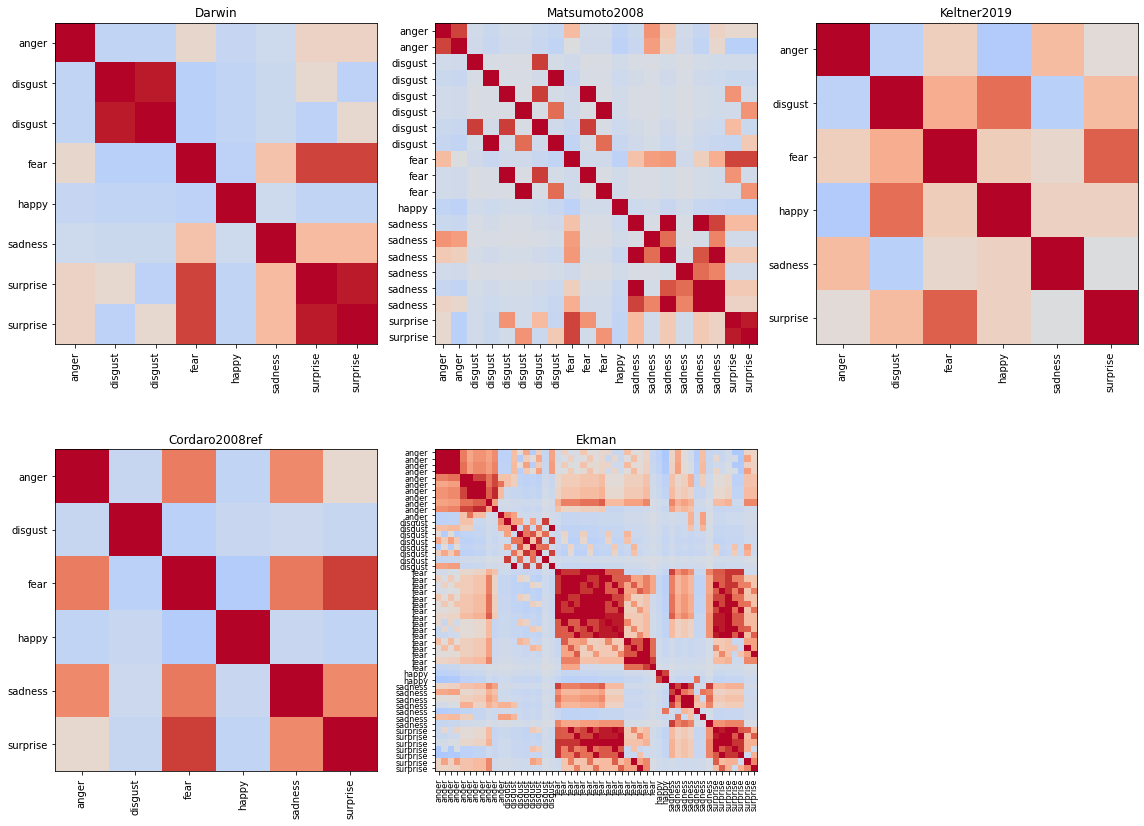

In [26]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 12))
for i, ax in enumerate(axes.flatten()[:-1]):
    cor = t_df[theories[i]].transpose().corr()
    mapp = ax.imshow(cor, vmin=-0.8, vmax=0.8, cmap='coolwarm')
    fs = 8 if list(THEORIES.keys())[i] == 'Ekman' else 10
    ax.set_xticks(range(cor.shape[0]))
    ax.set_xticklabels(cor.columns, rotation=90, fontsize=fs)
    ax.set_yticks(range(cor.shape[0]))
    ax.set_yticklabels(cor.index, fontsize=fs)
    ax.set_title(list(THEORIES.keys())[i])

ax = axes.flatten()[-1]
ax.axis('off')
#fig.colorbar(mapp, ax=axes.ravel().tolist(), pad=1)
fig.tight_layout()

Although theories might postulate different configurations for a single emotion (i.e., a "many-to-one mapping"), a proper predictive model should only generate probability distribution across a fixed set of classes (e.g., the six discrete emotions in our study). Therefore, in our analyses, whenever multiple configurations are hypothesized for a given emotion, we use the highest similarity value amongst the different configurations. Formally, for $C$ different configurations for a particular emotion $E_{j}$, we use the one that yields the maximum probability $P(E_{j} | T, S_{i})$:

\begin{align}
\phi_{i,j} := \underset{c}{\operatorname{max}}\phi_{i,j | c}
\end{align}

For example, suppose that theory $T$ has 3 different configurations for anger, as demonstrated below (using hypothetical 10-dimensional AU vectors):

In [27]:
T_anger = np.array([
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
])

Then, for a particular stimulus (e.g., $S_{i}$), we will use maximum similarity score across the $C$ configurations (here: 3):

In [28]:
np.max(S_i @ T_anger[0, :].T)

0.6

## Data used to evaluate theories
We use data from an existing dataset from Glasgow University which contains 2400 emotion ratings of random facial expressions from 60 subjects. Specifically, each stimulus was endowed with one or more of AUs, i.e., specific facial movements, ranging in amplitude from 0 (not activated) to 1 (fully activated), randomly drawn from a full set of 42 action units. As described before, the set 42 AUs was recoded into 34 AUs in order to remove the compound and bilateral AUs. Note that each stimulus was generated with a limited number of AUs; specifically, the the number of AUs per stimulus was drawn from a binomial distribution with $n=6$ and $p=0.5$: $N_{\mathrm{AU}} \sim \mathrm{Binom}(6, .5)$.

Below, we load in such a stimulus matrix for a particular participant:

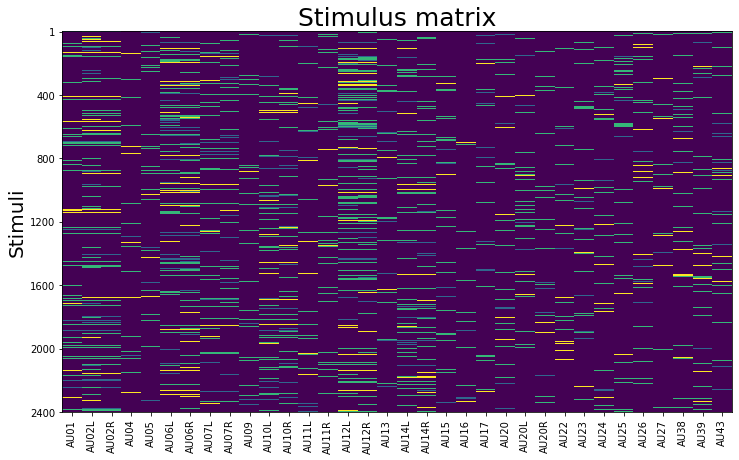

In [30]:
df = pd.read_csv('../data/ratings/sub-42_ratings.tsv', sep='\t', index_col=0)

plt.figure(figsize=(12, 7))
plt.imshow(df.iloc[:, :-2], aspect='auto', interpolation='none');
plt.yticks(np.append(np.arange(400, 2401, 400), 1))
plt.xticks(np.arange(34), df.columns[:-2], rotation=90)
plt.ylabel("Stimuli", fontsize=20)
plt.title("Stimulus matrix", fontsize=25);

Each participant's data also includes a categorical emotion rating ("anger", "disgust", "fear", "happiness", "sadness", "surprise"), which may be "Other" if the expression did not match one of the six categorical emotions, and an "intensity" rating, which ranged from 1 (not intensity at all) to 5 (very intense):

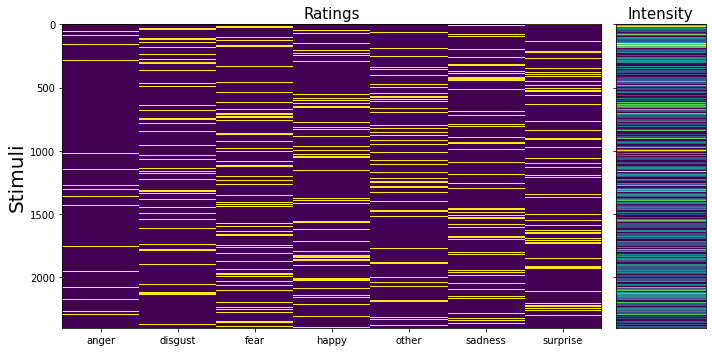

In [31]:
ratings = pd.get_dummies(df.iloc[:, -2])
intensity = df.iloc[:, -1].to_numpy()

fig, axes = plt.subplots(ncols=2, sharey=True, gridspec_kw={'width_ratios': [6, 1]},
                         figsize=(10, 5))
axes[0].imshow(ratings, aspect='auto', interpolation='none')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(ratings.columns)
axes[0].set_ylabel("Stimuli", fontsize=20)
axes[0].set_title("Ratings", fontsize=15)
axes[1].imshow(intensity[:, np.newaxis], aspect='auto', vmin=1, vmax=5, interpolation='none')
axes[1].set_title("Intensity", fontsize=15)
axes[1].set_xticks([])

fig.tight_layout()

## Analysis parameters
Previously, we discussed various settings (or "hyperparameters") for our theory kernel classifier (such as the inverse temperature parameter and kernel type). The result section reports results obtained with an inverse temperature parameter ($\beta$) of 1 and a linear (inner product) kernel, i.e.: $\sigma(\kappa(S_{i}, T^{T})$. As reported in the Supplementary Materials, the choice for the inverse temperature parameter and kernel type mattered little in terms of predictive performance (see Supplementary Figure X and Y).

# Results
Here, we describe the predictive performance of the different theories as implemented using theory kernels. While the results of the analysis can be summarized in a single predictive performance score (i.e., AUROC score) per emotion and theory, we report and visualize (in Figure X) both the average and the standard deviation across subjects, as well as the estimated noise ceiling (± one standard deviation estimated used bootstrapping).

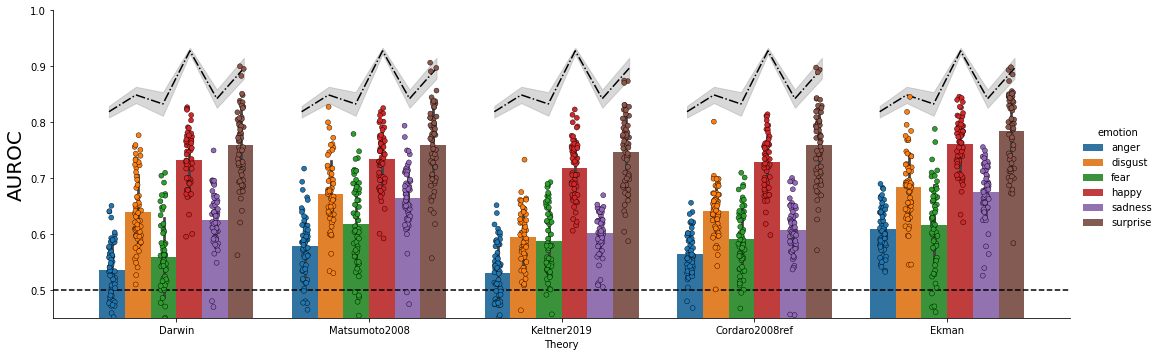

In [32]:
ymin = 0.45
ymax = 1
chance_level = .5

df = pd.read_csv('../results/auroc.tsv', sep='\t')
df = df.rename({'tk': "Theory"}, axis=1)
nc = pd.read_csv('../data/noise_ceilings.tsv', sep='\t', index_col=0)
# intensity == 0 refers to overall noise ceiling (not stratified within intensity quantile)
nc = nc.query("participant_id == 'between_subjects' & intensity == 0")

g = sns.catplot(x='Theory', y='score', data=df, hue='emotion',
                kind="bar", aspect=3, height=5, ci='sd')
ax = sns.stripplot(x='Theory', y='score', hue='emotion',
                   edgecolor='black', linewidth=0.4, data=df,
                   dodge=True, jitter=True)

ax.set_ylabel("AUROC", fontsize=20)

n_emo = df['emotion'].unique().size
n_tk = df['Theory'].unique().size
for i in range(n_tk):
    this_nc = nc['noise_ceiling']
    this_sd = nc['sd']
    plt.plot(np.linspace(i-0.35, i+0.35, num=6), this_nc, c='k', ls='-.')
    plt.fill_between(
        np.linspace(i-0.35, i+0.35, num=6),
        this_nc - this_sd, this_nc + this_sd,
        color='gray', alpha=0.3
)

ax = plt.gca()
ax.set_ylim(ymin, ymax)
ax.axhline(chance_level, c='k', ls='--')
ax.legend_.remove()

The results in Figure X show that most theories predict the different emotion ratings well above chance level (i.e., an AUROC of 0.5). Notably, though, the average predictive performance is still far the estimated noise ceiling for all theories, which suggests that there is room for improvement in terms of models of categorical emotion perception. Moreover, the fact that the noise ceilings are substantially below the theoretical maximum performance (i.e., an AUROC of 1) indicates that performance is limited by between-subject variance in the mapping between AUs and categorical emotions.

One thing that stands out are the high scores of "happiness" and "surprise" relative to the other emotions. From this, one could argue that the evaluated theories are biased in their preditive power towards these emotions. An alternative explanation, though, is that those relatively high scores are caused by less variance (i.e., more consistency) across subjects; indeed, the higher noise ceilings for happiness (0.93) and surprise (0.90) relative to the other emotions (0.82-0.84) suggest as such. Therefore, we visualized the same results in Figure X, but this time relative to the corresponding noise ceiling (i.e., each score is divided by the noise ceiling).

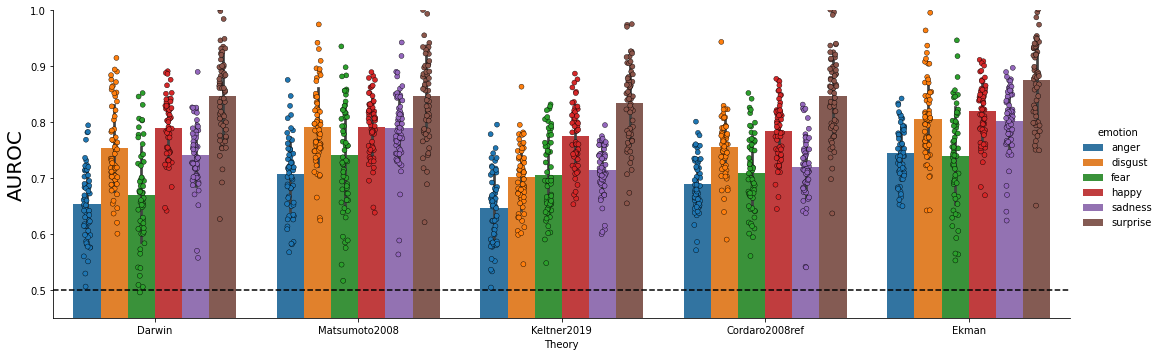

In [33]:
df_ncc = df.copy()
for emo in nc['emotion']:
    this_nc = nc.loc[nc['emotion'] == emo, 'noise_ceiling'].values[0]
    df_ncc.loc[df_ncc['emotion'] == emo, 'score'] = df_ncc.loc[df['emotion'] == emo, 'score'] / this_nc
    
g = sns.catplot(x='Theory', y='score', data=df_ncc, hue='emotion',
                kind="bar", aspect=3, height=5, ci='sd')
ax = sns.stripplot(x='Theory', y='score', hue='emotion',
              edgecolor='black', linewidth=0.4, data=df_ncc,
              dodge=True, jitter=True)

ax.set_ylabel("AUROC", fontsize=20)

ax = plt.gca()
ax.set_ylim(ymin, ymax)
ax.axhline(chance_level, c='k', ls='--')
ax.legend_.remove()

---

**To add**: maybe a confusion matrix of predictions and relate that to distances between theory vectors, i.e., show that confusions arise proportional to the distance of theory vectors.

---

One valid criticism of applying theory kernel analysis to psychophysics data, specifically, is that psychophysics data samples the AU space completely randomly, while the space in which emotional facial expressions likely occur in real life is arguably more restricted. This random sampling may thus have generated stimuli that are not "close" any one of the discrete emotion classes as defined in AU space. Some of these "ambiguous" stimuli may still have been rated as a (by virtue of the experimental design) discrete emotion by participants, which may thus unduly penalize predictive performance. Put differently, if the stimuli were not randomly sampled, but sampled according to the probability they occur in real life, model performance may be much higher than our results suggest.

---

**Note**: I'm not sure how clear/sound the argument (see below) about using "intensity" as a proxy for "confidence" is...

---

To investigate this, we stratified our results according to the *intensity* rating that participants gave in addition to the discrete emotion label. This way, we can use each stimulus' intensity value as a proxy for "confidence" and investigate whether performance increases with higher intensity levels. Figure X shows that, indeed, model performance for most emotions and theories goes up with increasing intensity. Importantly, though, the noise ceiling seems to increase along with model performance. This suggests that part of the unexplained variance may be due to the completely random sampling of stimuli, but the concurrent increase in the noise ceiling also suggests that the explanatory power of the theories, per se, does not necessarily improve with intensity. 

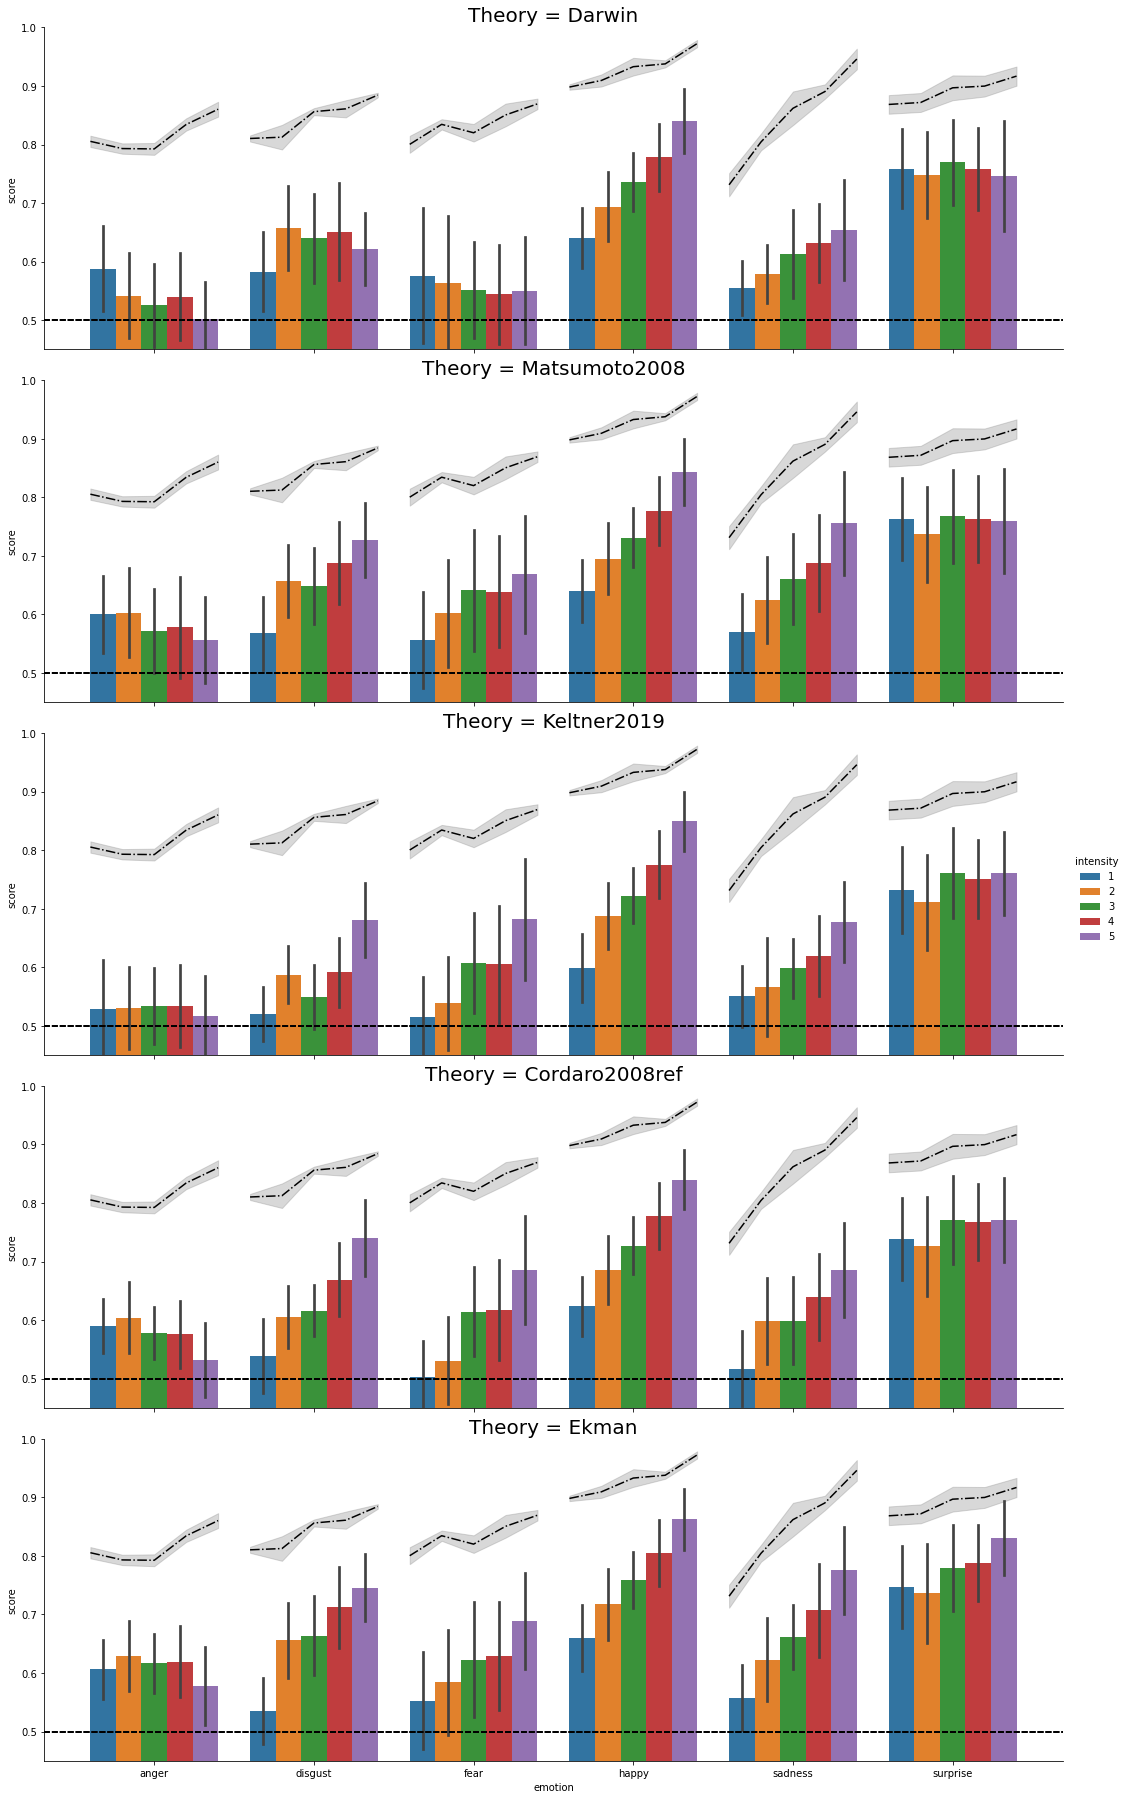

In [34]:
nc = pd.read_csv('../data/noise_ceilings.tsv', sep='\t', index_col=0)
nc = nc.query("participant_id == 'between_subjects' & intensity != 0")

df_int = pd.read_csv('../results/auroc_per_intensity_quantile.tsv', sep='\t', index_col=0)
df_int = df_int.rename({'tk': "Theory"}, axis=1)
g = sns.catplot(x='emotion', y='score', data=df_int, hue='intensity', row='Theory',
                kind="bar", aspect=3, height=5, ci='sd')
g.set_titles(size=20)

for ax in g.axes.flatten():
    
    for i, emo in enumerate(nc['emotion'].unique()):
        this_nc = nc.loc[nc['emotion'] == emo, 'noise_ceiling']
        this_sd = nc.loc[nc['emotion'] == emo, 'sd']
        ax.plot(np.linspace(i-0.4, i+0.4, num=5), this_nc, c='k', ls='-.')
        ax.fill_between(
            np.linspace(i-0.4, i+0.4, num=5),
            this_nc - this_sd, this_nc + this_sd,
            color='gray', alpha=0.3
        )
        ax.set_ylim(ymin, ymax)
        ax.axhline(0.5, ls='--', c='k')

# Discussion
* Reiteration of idea/research question
* Summary of findings
    * Theory kernel analysis yields sensible predictive performance estimates for all theories
    * Many-to-one (Ekman! and to a certain extent Matsumoto) theories perform better
    * Noise ceilings represent an upper bound to model performance and can be used to quantify how much models *can* be improved (i.e., the variance "in between" model performance and the noise ceiling) and how much is due to between-subject differences
    * Maybe state explicitly that our approach and results, and especially when interpreted relative to the noise ceiling, support both a (somewhat) reliable mapping between AUs and discrete emotions (as hypothesized in basic emotion theory) &mdash; as evident from the substantial above-chance performance &mdash; *and* for substantial individual differences in this mapping (or "idiosyncrasy") (as hypothesized in constructionism)
* Limitations
    * Temporal parameters were not included in design
    * Face identities not used
    * Theory kernel analysis assumes AUs are additively related to emotions, but they could also be related to emotions in terms of interactions
    * Something about generality of findings w.r.t. stimulus set used to evaluate
    * Only discrete ratings are available; probabilistic ratings would, technically, be better
    * Using "intensity" as a proxy for "confidence" is debatable
    * Regardless, pure random sampling (as in most psychophysics research) may be inefficient and suboptimal; alternative is to sample from a distribution that matches real world occurence more (without imposing too many assumptions)
* Future directions
    * Theory kernel analysis can be used to turn *any* "theory" into a predictive model, given an explicit mapping between stimulus features and some target (dependent) variable!
    * Extend to >6 emotions
    * Incorporate between-subject variables (age, gender, etc.) to improve model performance (i.e., "soak up" variance associated with between-subject "inconsistency")

# Supplementary Materials
* Figure with different beta/kernels
* Figure with distance metrics vs. similarity kernels